<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:11<00:00, 14.3MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


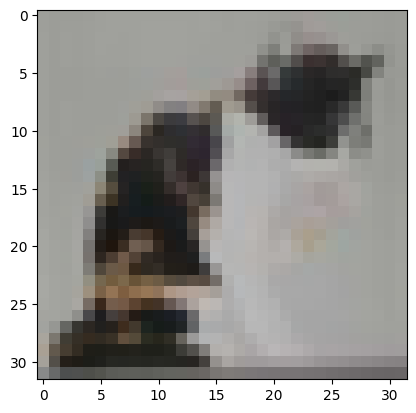

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train), transforms.RandomRotation(degrees=(-40, 40)), transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [6]:
#Creating dataloader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# **II. Model implementation**

In [7]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.LeakyReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [8]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [9]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])
    #self.activation = torch.nn.LeakyReLU(1e-2)

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers[:-1]:
      x = fc_layer(x)
      x = torch.nn.Dropout(0.2)(x)
      x = torch.nn.LeakyReLU(1e-2)(x)
    return self.fc_layers[-1](x)


# **III. Training and test**

In [10]:
def compute_Hf_Wf(conv_kernels, Hi, Wi):
    '''Computes the height and width of the output of the final convolutional layer. This function assumes a maxpool2D of kernel 2x2, as well as default stride(1), padding(0) and dilation(0) for both pooling and convolution.
    Parameters:
        * conv_kernels: a list or tuple of the kernels of the successive convolutional layers
        * Hi: Initial height
        * Wi: Initial width

    Outputs:
        * Hf: final height
        * Wf: final width
    '''

    Hf, Wf = Hi, Wi
    for k in conv_kernels:
      Hf = (Hf - (k - 1)) // 2
      Wf = (Wf - (k - 1)) // 2
    return Hf, Wf


conv_kernels, Hi, Wi = (5,3,3), 32, 32
Hf, Wf = compute_Hf_Wf(conv_kernels, Hi, Wi)
print(Hf, Wf)

2 2


In [11]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 64, 128)
out_channels = (64, 128, 256)
conv_kernels = (5, 3, 3)
Hf, Wf = compute_Hf_Wf(conv_kernels, H, W)
fc_dims = (out_channels[-1]*Hf*Wf, 512, 256, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_

In [12]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 1064202
Device is cuda


In [13]:
if device=="cuda": model = torch.compile(model)

In [14]:
optimizer = None #Just so that I can resume training

In [15]:
#Training and validation
nb_epochs = 150
if optimizer is None: optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
else: print(optimizer)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
    loss_val /= len(val_loader)
    if loss_val < best_loss:
      best_loss = loss_val
      best_model, best_epoch = model, epoch
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()


Epoch: 0


391it [01:34,  4.14it/s]
40it [00:01, 36.01it/s]


Loss_train: 2.1081 and loss_val: 2.3451
Epoch: 1


391it [01:33,  4.19it/s]
40it [00:01, 36.35it/s]


Loss_train: 1.9469 and loss_val: 2.9435
Epoch: 2


391it [01:33,  4.18it/s]
40it [00:01, 35.80it/s]


Loss_train: 1.8672 and loss_val: 2.9274
Epoch: 3


391it [01:33,  4.20it/s]
40it [00:01, 35.69it/s]


Loss_train: 1.8059 and loss_val: 2.4962
Epoch: 4


391it [01:33,  4.18it/s]
40it [00:01, 36.26it/s]


Loss_train: 1.7682 and loss_val: 2.4038
Epoch: 5


391it [01:33,  4.17it/s]
40it [00:01, 35.03it/s]


Loss_train: 1.7279 and loss_val: 2.7346
Epoch: 6


391it [01:34,  4.15it/s]
40it [00:01, 36.19it/s]


Loss_train: 1.7022 and loss_val: 2.7549
Epoch: 7


391it [01:35,  4.10it/s]
40it [00:01, 35.34it/s]


Loss_train: 1.6804 and loss_val: 2.6521
Epoch: 8


391it [01:34,  4.14it/s]
40it [00:01, 34.85it/s]


Loss_train: 1.6611 and loss_val: 2.7473
Epoch: 9


391it [01:34,  4.14it/s]
40it [00:01, 36.65it/s]


Loss_train: 1.6433 and loss_val: 2.6659
Epoch: 10


391it [01:38,  3.97it/s]
40it [00:01, 34.39it/s]


Loss_train: 1.6221 and loss_val: 2.4758
Epoch: 11


391it [01:36,  4.03it/s]
40it [00:01, 35.36it/s]


Loss_train: 1.6043 and loss_val: 2.3688
Epoch: 12


391it [01:34,  4.14it/s]
40it [00:01, 36.54it/s]


Loss_train: 1.5900 and loss_val: 2.4145
Epoch: 13


391it [01:33,  4.19it/s]
40it [00:01, 35.86it/s]


Loss_train: 1.5805 and loss_val: 2.3496
Epoch: 14


391it [01:34,  4.14it/s]
40it [00:01, 34.88it/s]


Loss_train: 1.5644 and loss_val: 2.3127
Epoch: 15


391it [01:35,  4.09it/s]
40it [00:01, 36.15it/s]


Loss_train: 1.5548 and loss_val: 2.3784
Epoch: 16


391it [01:34,  4.15it/s]
40it [00:01, 35.63it/s]


Loss_train: 1.5428 and loss_val: 2.3883
Epoch: 17


391it [01:36,  4.07it/s]
40it [00:01, 35.12it/s]


Loss_train: 1.5267 and loss_val: 2.1203
Epoch: 18


391it [01:36,  4.05it/s]
40it [00:01, 34.53it/s]


Loss_train: 1.5164 and loss_val: 2.2588
Epoch: 19


391it [01:38,  3.99it/s]
40it [00:01, 34.34it/s]


Loss_train: 1.5043 and loss_val: 2.1080
Epoch: 20


391it [01:39,  3.93it/s]
40it [00:01, 33.45it/s]


Loss_train: 1.4924 and loss_val: 2.0647
Epoch: 21


391it [01:37,  4.03it/s]
40it [00:01, 33.74it/s]


Loss_train: 1.4874 and loss_val: 2.2447
Epoch: 22


391it [01:39,  3.95it/s]
40it [00:01, 35.13it/s]


Loss_train: 1.4781 and loss_val: 2.1969
Epoch: 23


391it [01:38,  3.97it/s]
40it [00:01, 34.46it/s]


Loss_train: 1.4699 and loss_val: 2.1645
Epoch: 24


391it [01:34,  4.12it/s]
40it [00:01, 35.25it/s]


Loss_train: 1.4614 and loss_val: 2.2458
Epoch: 25


391it [01:32,  4.25it/s]
40it [00:01, 35.33it/s]


Loss_train: 1.4494 and loss_val: 2.1616
Epoch: 26


391it [01:34,  4.12it/s]
40it [00:01, 35.30it/s]


Loss_train: 1.4426 and loss_val: 2.1049
Epoch: 27


391it [01:36,  4.05it/s]
40it [00:01, 36.26it/s]


Loss_train: 1.4347 and loss_val: 2.0261
Epoch: 28


391it [01:35,  4.09it/s]
40it [00:01, 35.55it/s]


Loss_train: 1.4246 and loss_val: 2.1488
Epoch: 29


391it [01:35,  4.09it/s]
40it [00:01, 34.70it/s]


Loss_train: 1.4154 and loss_val: 2.2081
Epoch: 30


391it [01:35,  4.10it/s]
40it [00:01, 35.94it/s]


Loss_train: 1.4121 and loss_val: 2.1066
Epoch: 31


391it [01:34,  4.13it/s]
40it [00:01, 33.64it/s]


Loss_train: 1.4045 and loss_val: 2.1200
Epoch: 32


391it [01:34,  4.13it/s]
40it [00:01, 35.91it/s]


Loss_train: 1.3942 and loss_val: 2.1317
Epoch: 33


391it [01:35,  4.08it/s]
40it [00:01, 35.51it/s]


Loss_train: 1.3885 and loss_val: 2.0235
Epoch: 34


391it [01:34,  4.13it/s]
40it [00:01, 36.13it/s]


Loss_train: 1.3878 and loss_val: 2.1252
Epoch: 35


391it [01:36,  4.05it/s]
40it [00:01, 36.26it/s]


Loss_train: 1.3737 and loss_val: 2.0835
Epoch: 36


391it [01:37,  4.00it/s]
40it [00:01, 33.95it/s]


Loss_train: 1.3737 and loss_val: 2.1260
Epoch: 37


391it [01:36,  4.04it/s]
40it [00:01, 35.77it/s]


Loss_train: 1.3681 and loss_val: 2.1060
Epoch: 38


391it [01:35,  4.10it/s]
40it [00:01, 36.08it/s]


Loss_train: 1.3615 and loss_val: 2.0424
Epoch: 39


391it [01:35,  4.09it/s]
40it [00:01, 35.95it/s]


Loss_train: 1.3590 and loss_val: 2.0862
Epoch: 40


391it [01:35,  4.08it/s]
40it [00:01, 35.16it/s]


Loss_train: 1.3482 and loss_val: 2.0555
Epoch: 41


391it [01:35,  4.10it/s]
40it [00:01, 34.57it/s]


Loss_train: 1.3454 and loss_val: 2.0412
Epoch: 42


391it [01:35,  4.11it/s]
40it [00:01, 35.56it/s]


Loss_train: 1.3415 and loss_val: 2.1504
Epoch: 43


391it [01:35,  4.11it/s]
40it [00:01, 35.57it/s]


Loss_train: 1.3325 and loss_val: 2.1891
Epoch: 44


391it [01:35,  4.08it/s]
40it [00:01, 35.39it/s]


Loss_train: 1.3302 and loss_val: 2.1079
Epoch: 45


391it [01:36,  4.05it/s]
40it [00:01, 35.03it/s]


Loss_train: 1.3215 and loss_val: 2.0034
Epoch: 46


391it [01:35,  4.08it/s]
40it [00:01, 35.30it/s]


Loss_train: 1.3205 and loss_val: 2.1311
Epoch: 47


391it [01:35,  4.11it/s]
40it [00:01, 34.22it/s]


Loss_train: 1.3135 and loss_val: 2.1035
Epoch: 48


391it [01:34,  4.12it/s]
40it [00:01, 36.46it/s]


Loss_train: 1.3145 and loss_val: 2.1469
Epoch: 49


391it [01:35,  4.11it/s]
40it [00:01, 35.91it/s]


Loss_train: 1.3048 and loss_val: 2.1890
Epoch: 50


391it [01:37,  3.99it/s]
40it [00:01, 35.01it/s]


Loss_train: 1.3017 and loss_val: 2.0896
Epoch: 51


391it [01:38,  3.99it/s]
40it [00:01, 33.34it/s]


Loss_train: 1.2987 and loss_val: 2.1381
Epoch: 52


391it [01:37,  4.00it/s]
40it [00:01, 33.64it/s]


Loss_train: 1.2961 and loss_val: 2.1368
Epoch: 53


391it [01:42,  3.81it/s]
40it [00:01, 31.73it/s]


Loss_train: 1.2904 and loss_val: 2.1598
Epoch: 54


391it [01:39,  3.91it/s]
40it [00:01, 34.61it/s]


Loss_train: 1.2862 and loss_val: 2.1195
Epoch: 55


391it [01:39,  3.92it/s]
40it [00:01, 34.33it/s]


Loss_train: 1.2787 and loss_val: 2.1256
Epoch: 56


391it [01:38,  3.97it/s]
40it [00:01, 33.45it/s]


Loss_train: 1.2762 and loss_val: 2.1818
Epoch: 57


391it [01:38,  3.97it/s]
40it [00:01, 34.63it/s]


Loss_train: 1.2737 and loss_val: 2.1026
Epoch: 58


391it [01:36,  4.05it/s]
40it [00:01, 32.17it/s]


Loss_train: 1.2671 and loss_val: 1.9802
Epoch: 59


391it [01:34,  4.13it/s]
40it [00:01, 35.23it/s]


Loss_train: 1.2674 and loss_val: 2.0862
Epoch: 60


391it [01:34,  4.13it/s]
40it [00:01, 36.05it/s]


Loss_train: 1.2625 and loss_val: 2.1433
Epoch: 61


391it [01:35,  4.11it/s]
40it [00:01, 35.28it/s]


Loss_train: 1.2602 and loss_val: 2.1230
Epoch: 62


391it [01:33,  4.17it/s]
40it [00:01, 35.89it/s]


Loss_train: 1.2564 and loss_val: 2.0842
Epoch: 63


391it [01:34,  4.15it/s]
40it [00:01, 35.72it/s]


Loss_train: 1.2543 and loss_val: 2.0679
Epoch: 64


391it [01:35,  4.10it/s]
40it [00:01, 36.04it/s]


Loss_train: 1.2488 and loss_val: 2.1323
Epoch: 65


391it [01:35,  4.11it/s]
40it [00:01, 35.53it/s]


Loss_train: 1.2426 and loss_val: 2.0500
Epoch: 66


391it [01:34,  4.15it/s]
40it [00:01, 35.96it/s]


Loss_train: 1.2400 and loss_val: 2.1050
Epoch: 67


391it [01:34,  4.14it/s]
40it [00:01, 35.56it/s]


Loss_train: 1.2371 and loss_val: 2.0614
Epoch: 68


391it [01:34,  4.12it/s]
40it [00:01, 34.62it/s]


Loss_train: 1.2393 and loss_val: 2.0617
Epoch: 69


391it [01:34,  4.13it/s]
40it [00:01, 35.70it/s]


Loss_train: 1.2324 and loss_val: 2.1480
Epoch: 70


391it [01:33,  4.18it/s]
40it [00:01, 35.05it/s]


Loss_train: 1.2294 and loss_val: 2.1146
Epoch: 71


391it [01:33,  4.17it/s]
40it [00:01, 36.12it/s]


Loss_train: 1.2251 and loss_val: 2.1156
Epoch: 72


391it [01:35,  4.11it/s]
40it [00:01, 35.89it/s]


Loss_train: 1.2206 and loss_val: 2.2114
Epoch: 73


391it [01:33,  4.18it/s]
40it [00:01, 36.42it/s]


Loss_train: 1.2214 and loss_val: 2.1138
Epoch: 74


391it [01:34,  4.15it/s]
40it [00:01, 36.55it/s]


Loss_train: 1.2166 and loss_val: 2.1270
Epoch: 75


391it [01:34,  4.14it/s]
40it [00:01, 36.31it/s]


Loss_train: 1.2163 and loss_val: 2.1302
Epoch: 76


391it [01:38,  3.98it/s]
40it [00:01, 35.36it/s]


Loss_train: 1.2124 and loss_val: 2.2009
Epoch: 77


391it [01:35,  4.10it/s]
40it [00:01, 36.24it/s]


Loss_train: 1.2115 and loss_val: 2.1867
Epoch: 78


391it [01:35,  4.09it/s]
40it [00:01, 34.95it/s]


Loss_train: 1.2077 and loss_val: 2.1330
Epoch: 79


391it [01:34,  4.14it/s]
40it [00:01, 35.27it/s]


Loss_train: 1.2028 and loss_val: 2.0726
Epoch: 80


391it [01:36,  4.06it/s]
40it [00:01, 35.19it/s]


Loss_train: 1.2022 and loss_val: 2.1023
Epoch: 81


391it [01:38,  3.97it/s]
40it [00:01, 34.57it/s]


Loss_train: 1.1971 and loss_val: 2.0522
Epoch: 82


391it [01:38,  3.98it/s]
40it [00:01, 34.71it/s]


Loss_train: 1.1912 and loss_val: 2.1090
Epoch: 83


391it [01:37,  4.01it/s]
40it [00:01, 36.14it/s]


Loss_train: 1.1911 and loss_val: 2.1446
Epoch: 84


391it [01:37,  4.00it/s]
40it [00:01, 32.42it/s]


Loss_train: 1.1921 and loss_val: 2.1414
Epoch: 85


391it [01:36,  4.07it/s]
40it [00:01, 35.83it/s]


Loss_train: 1.1894 and loss_val: 2.1433
Epoch: 86


391it [01:37,  4.00it/s]
40it [00:01, 35.12it/s]


Loss_train: 1.1841 and loss_val: 2.0772
Epoch: 87


391it [01:39,  3.94it/s]
40it [00:01, 35.42it/s]


Loss_train: 1.1810 and loss_val: 2.0562
Epoch: 88


391it [01:35,  4.08it/s]
40it [00:01, 35.82it/s]


Loss_train: 1.1829 and loss_val: 2.0530
Epoch: 89


391it [01:37,  4.01it/s]
40it [00:01, 34.96it/s]


Loss_train: 1.1791 and loss_val: 2.1200
Epoch: 90


391it [01:36,  4.04it/s]
40it [00:01, 33.76it/s]


Loss_train: 1.1751 and loss_val: 2.1113
Epoch: 91


391it [01:36,  4.06it/s]
40it [00:01, 35.61it/s]


Loss_train: 1.1741 and loss_val: 2.0738
Epoch: 92


391it [01:36,  4.05it/s]
40it [00:01, 35.27it/s]


Loss_train: 1.1697 and loss_val: 2.0809
Epoch: 93


391it [01:35,  4.09it/s]
40it [00:01, 36.09it/s]


Loss_train: 1.1673 and loss_val: 2.0850
Epoch: 94


391it [01:36,  4.05it/s]
40it [00:01, 36.10it/s]


Loss_train: 1.1681 and loss_val: 2.0934
Epoch: 95


391it [01:37,  4.02it/s]
40it [00:01, 35.03it/s]


Loss_train: 1.1664 and loss_val: 2.0520
Epoch: 96


391it [01:34,  4.13it/s]
40it [00:01, 35.91it/s]


Loss_train: 1.1606 and loss_val: 2.0928
Epoch: 97


391it [01:38,  3.98it/s]
40it [00:01, 35.73it/s]


Loss_train: 1.1605 and loss_val: 2.0722
Epoch: 98


391it [01:35,  4.11it/s]
40it [00:01, 35.49it/s]


Loss_train: 1.1599 and loss_val: 2.1452
Epoch: 99


391it [01:37,  4.01it/s]
40it [00:01, 35.16it/s]


Loss_train: 1.1557 and loss_val: 2.1382
Epoch: 100


391it [01:36,  4.03it/s]
40it [00:01, 34.19it/s]


Loss_train: 1.1561 and loss_val: 2.1358
Epoch: 101


391it [01:38,  3.98it/s]
40it [00:01, 35.36it/s]


Loss_train: 1.1519 and loss_val: 2.2953
Epoch: 102


391it [01:37,  3.99it/s]
40it [00:01, 34.59it/s]


Loss_train: 1.1530 and loss_val: 2.0982
Epoch: 103


391it [01:38,  3.95it/s]
40it [00:01, 32.09it/s]


Loss_train: 1.1504 and loss_val: 2.0981
Epoch: 104


391it [01:41,  3.85it/s]
40it [00:01, 34.83it/s]


Loss_train: 1.1487 and loss_val: 2.1204
Epoch: 105


391it [01:37,  4.01it/s]
40it [00:01, 34.59it/s]


Loss_train: 1.1447 and loss_val: 2.2424
Epoch: 106


391it [01:33,  4.17it/s]
40it [00:01, 36.45it/s]


Loss_train: 1.1440 and loss_val: 2.2050
Epoch: 107


391it [01:33,  4.19it/s]
40it [00:01, 36.82it/s]


Loss_train: 1.1433 and loss_val: 2.1614
Epoch: 108


391it [01:33,  4.18it/s]
40it [00:01, 35.68it/s]


Loss_train: 1.1398 and loss_val: 2.1433
Epoch: 109


391it [01:34,  4.16it/s]
40it [00:01, 35.64it/s]


Loss_train: 1.1377 and loss_val: 2.1035
Epoch: 110


391it [01:36,  4.06it/s]
40it [00:01, 36.82it/s]


Loss_train: 1.1300 and loss_val: 2.0930
Epoch: 111


391it [01:35,  4.11it/s]
40it [00:01, 35.72it/s]


Loss_train: 1.1342 and loss_val: 2.1493
Epoch: 112


391it [01:33,  4.17it/s]
40it [00:01, 36.79it/s]


Loss_train: 1.1293 and loss_val: 2.1831
Epoch: 113


391it [01:33,  4.20it/s]
40it [00:01, 36.96it/s]


Loss_train: 1.1342 and loss_val: 2.1432
Epoch: 114


391it [01:31,  4.30it/s]
40it [00:01, 36.01it/s]


Loss_train: 1.1314 and loss_val: 2.1912
Epoch: 115


391it [01:31,  4.26it/s]
40it [00:01, 36.51it/s]


Loss_train: 1.1258 and loss_val: 2.1726
Epoch: 116


391it [01:32,  4.22it/s]
40it [00:01, 36.08it/s]


Loss_train: 1.1262 and loss_val: 2.0902
Epoch: 117


391it [01:34,  4.15it/s]
40it [00:01, 37.03it/s]


Loss_train: 1.1255 and loss_val: 2.0900
Epoch: 118


391it [01:35,  4.09it/s]
40it [00:01, 35.44it/s]


Loss_train: 1.1212 and loss_val: 2.2231
Epoch: 119


391it [01:35,  4.11it/s]
40it [00:01, 36.23it/s]


Loss_train: 1.1207 and loss_val: 2.1697
Epoch: 120


391it [01:37,  4.00it/s]
40it [00:01, 34.83it/s]


Loss_train: 1.1174 and loss_val: 2.1153
Epoch: 121


391it [01:38,  3.98it/s]
40it [00:01, 35.20it/s]


Loss_train: 1.1155 and loss_val: 2.1891
Epoch: 122


391it [01:35,  4.09it/s]
40it [00:01, 35.36it/s]


Loss_train: 1.1174 and loss_val: 2.1457
Epoch: 123


391it [01:36,  4.06it/s]
40it [00:01, 36.07it/s]


Loss_train: 1.1161 and loss_val: 2.2256
Epoch: 124


391it [01:37,  4.01it/s]
40it [00:01, 36.14it/s]


Loss_train: 1.1140 and loss_val: 2.1610
Epoch: 125


391it [01:35,  4.11it/s]
40it [00:01, 36.70it/s]


Loss_train: 1.1081 and loss_val: 2.1724
Epoch: 126


391it [01:36,  4.06it/s]
40it [00:01, 35.09it/s]


Loss_train: 1.1080 and loss_val: 2.2046
Epoch: 127


391it [01:38,  3.99it/s]
40it [00:01, 36.25it/s]


Loss_train: 1.1079 and loss_val: 2.1911
Epoch: 128


391it [01:37,  4.00it/s]
40it [00:01, 34.84it/s]


Loss_train: 1.1087 and loss_val: 2.1615
Epoch: 129


391it [01:35,  4.09it/s]
40it [00:01, 35.72it/s]


Loss_train: 1.1036 and loss_val: 2.2643
Epoch: 130


391it [01:34,  4.14it/s]
40it [00:01, 35.30it/s]


Loss_train: 1.1070 and loss_val: 2.1578
Epoch: 131


391it [01:34,  4.16it/s]
40it [00:01, 36.46it/s]


Loss_train: 1.1031 and loss_val: 2.2015
Epoch: 132


391it [01:34,  4.15it/s]
40it [00:01, 34.52it/s]


Loss_train: 1.1000 and loss_val: 2.1886
Epoch: 133


391it [01:35,  4.09it/s]
40it [00:01, 35.43it/s]


Loss_train: 1.0968 and loss_val: 2.1912
Epoch: 134


391it [01:36,  4.05it/s]
40it [00:01, 35.07it/s]


Loss_train: 1.0966 and loss_val: 2.2051
Epoch: 135


391it [01:33,  4.20it/s]
40it [00:01, 36.31it/s]


Loss_train: 1.0952 and loss_val: 2.1701
Epoch: 136


391it [01:34,  4.14it/s]
40it [00:01, 36.81it/s]


Loss_train: 1.0970 and loss_val: 2.2319
Epoch: 137


391it [01:36,  4.07it/s]
40it [00:01, 34.36it/s]


Loss_train: 1.0906 and loss_val: 2.2165
Epoch: 138


391it [01:35,  4.08it/s]
40it [00:01, 36.05it/s]


Loss_train: 1.0921 and loss_val: 2.2706
Epoch: 139


391it [01:33,  4.19it/s]
40it [00:01, 37.20it/s]


Loss_train: 1.0910 and loss_val: 2.3015
Epoch: 140


391it [01:34,  4.13it/s]
40it [00:01, 36.58it/s]


Loss_train: 1.0888 and loss_val: 2.2023
Epoch: 141


391it [01:33,  4.20it/s]
40it [00:01, 36.93it/s]


Loss_train: 1.0921 and loss_val: 2.1738
Epoch: 142


391it [01:33,  4.20it/s]
40it [00:01, 36.70it/s]


Loss_train: 1.0874 and loss_val: 2.2315
Epoch: 143


391it [01:31,  4.25it/s]
40it [00:01, 35.80it/s]


Loss_train: 1.0828 and loss_val: 2.2541
Epoch: 144


391it [01:33,  4.19it/s]
40it [00:01, 37.04it/s]


Loss_train: 1.0870 and loss_val: 2.2388
Epoch: 145


391it [01:34,  4.14it/s]
40it [00:01, 35.27it/s]


Loss_train: 1.0861 and loss_val: 2.1583
Epoch: 146


391it [01:34,  4.16it/s]
40it [00:01, 36.15it/s]


Loss_train: 1.0807 and loss_val: 2.1365
Epoch: 147


391it [01:34,  4.15it/s]
40it [00:01, 36.42it/s]


Loss_train: 1.0799 and loss_val: 2.2427
Epoch: 148


391it [01:35,  4.10it/s]
40it [00:01, 36.36it/s]


Loss_train: 1.0806 and loss_val: 2.2423
Epoch: 149


391it [01:36,  4.06it/s]
40it [00:01, 36.65it/s]

Loss_train: 1.0766 and loss_val: 2.3235


Time elapsed: 97.47871375083923
Seconds per epoch: 0.6498580916722616
Best epoch: 58
Best loss: 1.9802


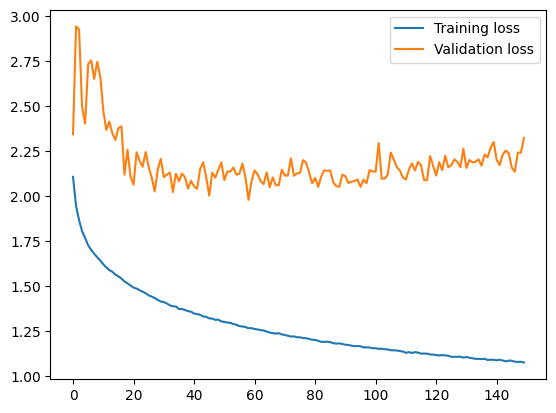

In [16]:
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {best_loss:.4f}")

epochs = range(nb_epochs)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [17]:
#Test on val data
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


40it [00:01, 35.49it/s]

Loss_test: 2.3067


<Axes: >

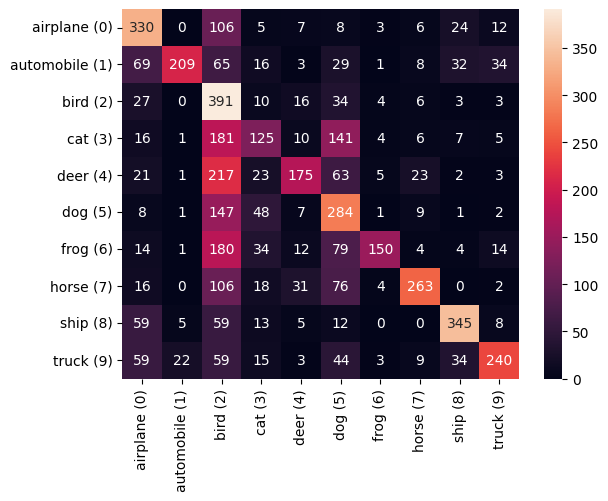

In [18]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [19]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.5024


In [20]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
bird (2)        0.791498
ship (8)        0.681818
airplane (0)    0.658683
dog (5)         0.559055
horse (7)       0.509690
truck (9)       0.491803
automobile (1)  0.448498
deer (4)        0.328330
frog (6)        0.304878
cat (3)         0.252016
Mean of accuracies:  0.502626934980559


In [21]:
checkpoint = {
    "model": best_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best_loss": best_loss,
    "epoch": best_epoch
}

# Save to a file in the working directory
torch.save(checkpoint, "/kaggle/working/checkpoint_LeakyReLU_dropout.pth")